In [9]:
import os
import re
import numpy as np
import pandas as pd
from collections import defaultdict


folder_path = r"results_TRN_internal\Evaluated"
data_by_config = defaultdict(list)


# === 3️⃣ 遍历文件夹中所有 CSV 文件 ===
for filename in os.listdir(folder_path):
    if not filename.endswith(".csv"):
        continue  # 跳过非 CSV 文件
        
    print(filename)
    # 示例文件名: books_summaries_generator_gemini-2.5-flash_temperature_0.4.csv
    match = re.search(r"generator_(.*?)_temperature_([\d.]+)(?:_\d+)?\.csv", filename)
    if not match:
        print('something wrong')
        continue  # 文件名不符合格式则跳过

    generator = match.group(1)
    temperature = float(match.group(2))
    key = (generator, temperature)
    
    # 读取 CSV 文件
    filepath = os.path.join(folder_path, filename)
    df = pd.read_csv(filepath)

    # 确认所需列存在
    required_cols = {'book_title', 'score_gemini', 'score_gpt'}
    if not required_cols.issubset(df.columns):
        print(f"⚠️ 文件缺列，跳过: {filename}")
        continue
        
    data_by_config[key].append(df)
    

books_summaries_generator_gemini-2.5-flash_temperature_0.4_1.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.4_2.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.4_3.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.4_4.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.4_5.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.9_1.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.9_2.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.9_3.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.9_4.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.9_5.csv
books_summaries_generator_gpt-4.1_temperature_0.4_1.csv
books_summaries_generator_gpt-4.1_temperature_0.4_2.csv
books_summaries_generator_gpt-4.1_temperature_0.4_3.csv
books_summaries_generator_gpt-4.1_temperature_0.4_4.csv
books_summaries_generator_gpt-4.1_temperature_0.4_5.csv
books_summaries_generator_gpt-4.1_temperature_0.9_1.csv
books_summarie

In [10]:
merged_results = {}

for key, df_list in data_by_config.items():
    # 将相同配置下的所有运行结果合并
    merged_df = pd.concat(df_list, ignore_index=True)
    
    # 按 book_title 聚合求平均值和标准差
    stats_df = merged_df.groupby('book_title')[['score_gemini', 'score_gpt']].agg(['mean','std'])
    
    # 如果希望列名是平铺的字符串而不是 MultiIndex
    stats_df.columns = [f"{col}_{stat}" for col, stat in stats_df.columns]
    stats_df = stats_df.reset_index()
    # 例如列名变为: 'book_title', 'score_gemini_mean', 'score_gemini_std', 'score_gpt_mean', 'score_gpt_std'

    # 整体平均值和标准差（可选）
    overall_avg = {
        "score_gemini_mean": stats_df['score_gemini_mean'].mean(),
        "score_gemini_std": stats_df['score_gemini_mean'].std(),
        "score_gpt_mean": stats_df['score_gpt_mean'].mean(),
        "score_gpt_std": stats_df['score_gpt_mean'].std()
    }
    
    merged_results[key] = {
        "stats_per_book": stats_df,   # 保存平均值和标准差
        "overall_avg": overall_avg
    }

In [14]:
generators = sorted({g for g, _ in merged_results.keys()})
temperatures = sorted({t for _, t in merged_results.keys()})
judges = ["gemini-2.5-flash", "gpt-4.1"]

# 初始化矩阵 (温度, Judge, Generator)
data_mean = np.zeros((len(temperatures), len(judges), len(generators)))
data_std  = np.zeros((len(temperatures), len(judges), len(generators)))

# 填充数据
for (generator, temperature), results in merged_results.items():
    g_idx = generators.index(generator)
    t_idx = temperatures.index(temperature)
    avg = results["overall_avg"]
    
    # 平均值
    data_mean[t_idx, 0, g_idx] = avg["score_gemini_mean"]
    data_mean[t_idx, 1, g_idx] = avg["score_gpt_mean"]
    
    # 标准差
    data_std[t_idx, 0, g_idx] = avg["score_gemini_std"]
    data_std[t_idx, 1, g_idx] = avg["score_gpt_std"]


✅ Data_mean shape: (2, 2, 2)
✅ Data_std  shape: (2, 2, 2)


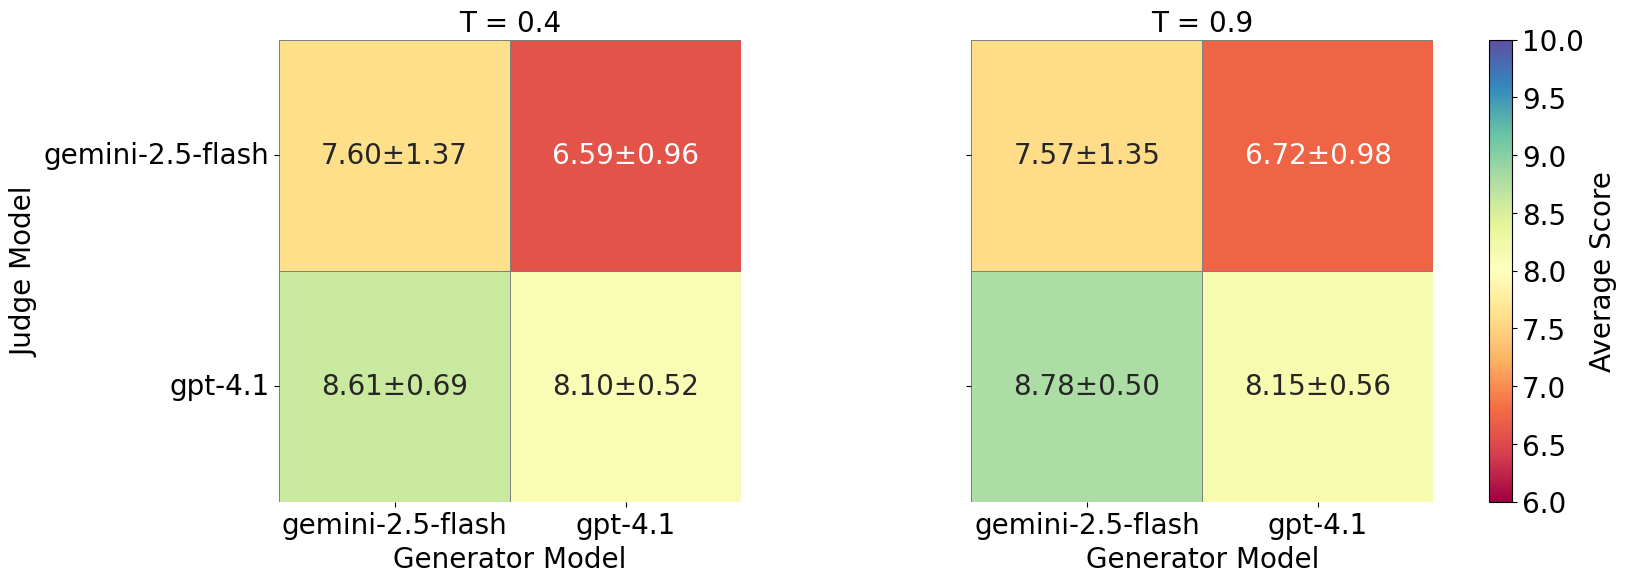

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

generators = ["gemini-2.5-flash", "gpt-4.1"]
judges = ["gemini-2.5-flash", "gpt-4.1"]
temperatures = [0.4, 0.9]

fontsize = 20
vmin, vmax = 6, 10
cmap = "Spectral"
norm = plt.Normalize(vmin=vmin, vmax=vmax)

fig, axes = plt.subplots(1, len(temperatures), figsize=(9*len(temperatures), 6), sharey=True)

for i, T in enumerate(temperatures):
    # 构建 DataFrame 用于 heatmap
    df_mean = pd.DataFrame(data_mean[i], index=judges, columns=generators)
    df_std  = pd.DataFrame(data_std[i], index=judges, columns=generators)

    # 构建显示字符串矩阵 "mean ± std"
    annot_matrix = df_mean.copy().astype(object)
    for r in range(len(judges)):
        for c in range(len(generators)):
            mean_val = df_mean.iloc[r, c]
            std_val  = df_std.iloc[r, c]
            annot_matrix.iloc[r, c] = f"{mean_val:.2f}±{std_val:.2f}"

    sns.heatmap(
        df_mean,                   # 颜色由平均值控制
        annot=annot_matrix,         # 显示平均值 ± 标准差
        fmt='',
        cmap=cmap,
        cbar=False,
        linewidths=0.5,
        linecolor="gray",
        ax=axes[i],
        square=True,
        annot_kws={"size": fontsize},
        vmin=vmin,
        vmax=vmax
    )

    axes[i].set_title(f"T = {T}", fontsize=fontsize)
    axes[i].set_xlabel("Generator Model", fontsize=fontsize)
    if i == 0:
        axes[i].set_ylabel("Judge Model", fontsize=fontsize)
    else:
        axes[i].set_ylabel("")
    axes[i].tick_params(axis='x', rotation=0, labelsize=fontsize)
    axes[i].tick_params(axis='y', rotation=0, labelsize=fontsize)

# 单独 colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.04)
cbar.set_label("Average Score", fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.savefig('Figures/all_mean_std.png', dpi=300, bbox_inches='tight')  # 去掉多余白边
plt.show()


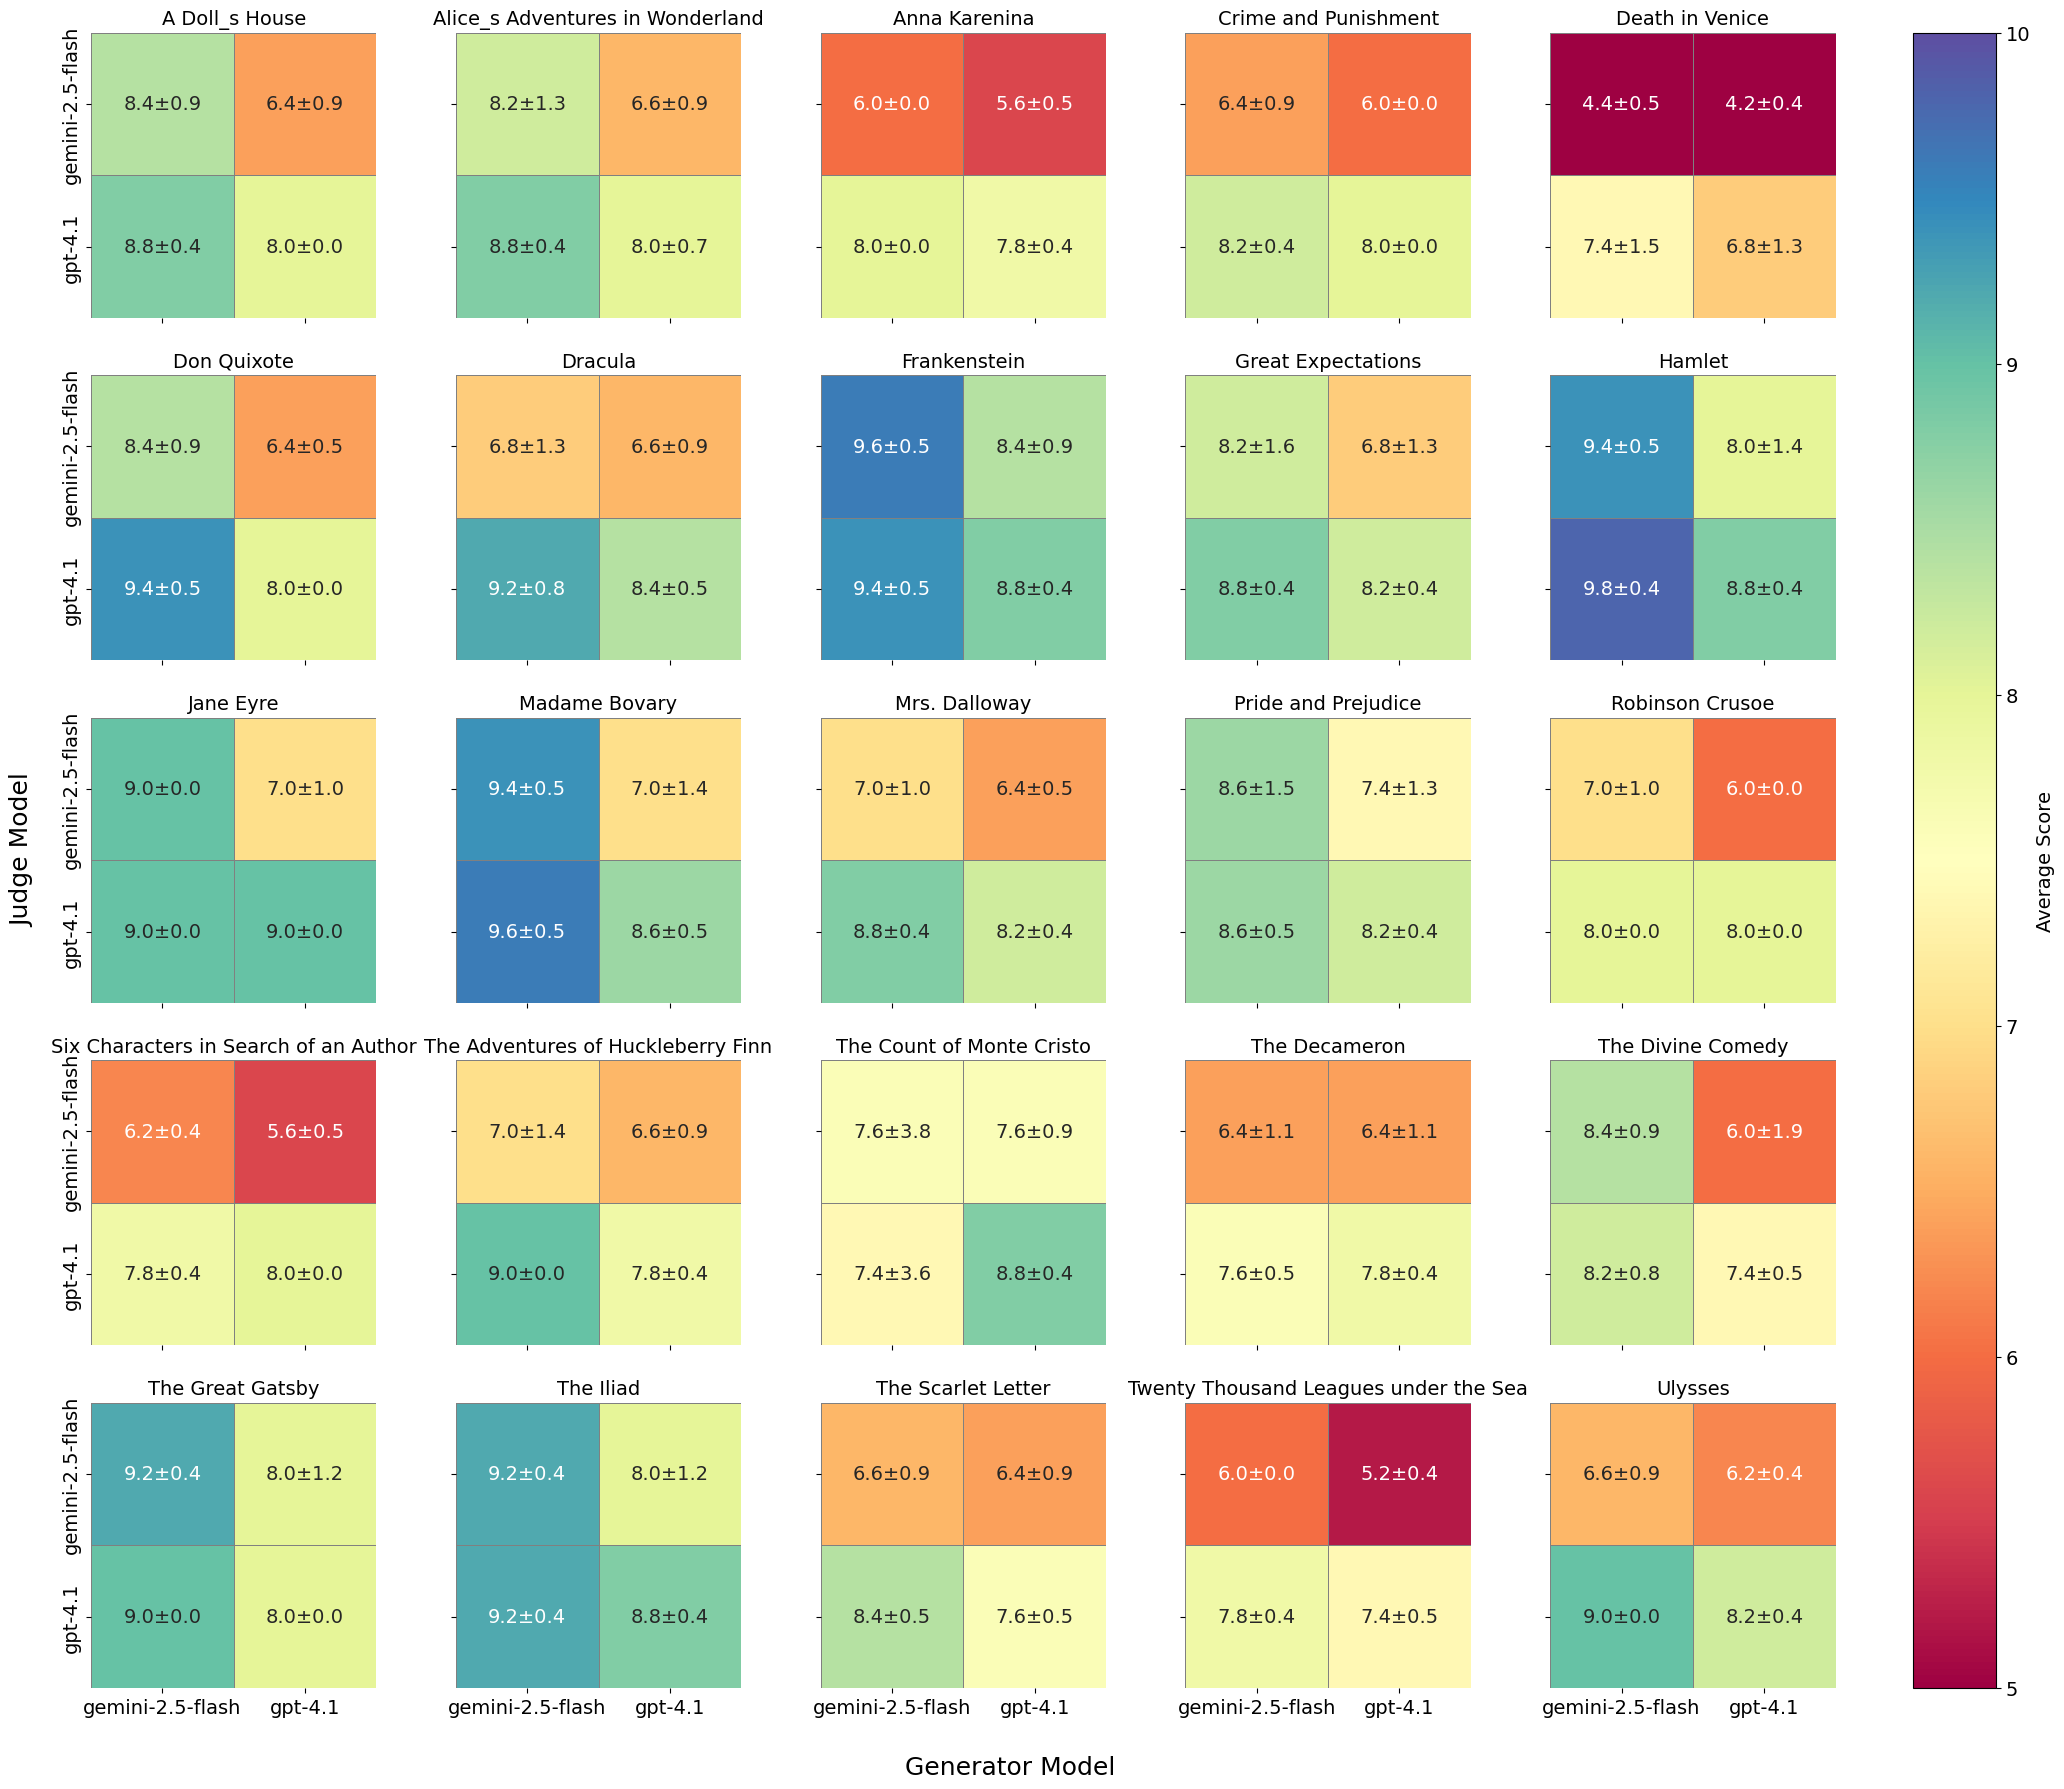

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ==== 数据准备 ====
generators = ["gemini-2.5-flash", "gpt-4.1"]
judges = ["gemini-2.5-flash", "gpt-4.1"]
temperature = 0.4
book_titles = merged_results[("gemini-2.5-flash", temperature)]["stats_per_book"]["book_title"].tolist()

vmin, vmax = 5, 10  # 统一颜色范围
fontsize = 14

# ==== 创建多个子图 ====
cols = 5
rows = int(np.ceil(len(book_titles) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4.3*rows))
axes = axes.flatten()

# ==== 绘制每本书 ====
for i, book in enumerate(book_titles):
    # 构造 2x2 数据矩阵
    matrix = np.zeros((2, 2))
    annot_matrix = np.empty((2, 2), dtype=object)  # object 类型，用于存字符串
    for r, generator in enumerate(generators):
        key = (generator, temperature)
        if key in merged_results:
            df = merged_results[key]["stats_per_book"]
            score_row = df[df["book_title"] == book]
            if not score_row.empty:
                # 平均值矩阵用于 heatmap 颜色
                matrix[0, r] = score_row["score_gemini_mean"].values[0]
                matrix[1, r] = score_row["score_gpt_mean"].values[0]
                # 构建显示字符串 "mean ± std"
                annot_matrix[0, r] = f"{score_row['score_gemini_mean'].values[0]:.1f}±{score_row['score_gemini_std'].values[0]:.1f}"
                annot_matrix[1, r] = f"{score_row['score_gpt_mean'].values[0]:.1f}±{score_row['score_gpt_std'].values[0]:.1f}"

    df_matrix = pd.DataFrame(matrix, index=judges, columns=generators)
    sns.heatmap(df_matrix, annot=annot_matrix, fmt='', cmap="Spectral",
                cbar=False, vmin=vmin, vmax=vmax, 
                linewidths=0.5, linecolor="gray", 
                ax=axes[i], square=True, annot_kws={"size": fontsize})

    axes[i].set_title(book.split("-")[0], fontsize=fontsize)       

# 去掉多余子图
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# 添加全局标签
fig.text(0.5, 0.07, "Generator Model", ha='center', fontsize=fontsize+4)
fig.text(0.1, 0.5, "Judge Model", va='center', rotation='vertical', fontsize=fontsize+4)

# 调整每个子图的 tick 显示
for i, ax in enumerate(axes):
    row, col = divmod(i, cols)
    if col != 0:  # 非最左列
        ax.set_ylabel("")
        ax.set_yticklabels([])
    else:  # 最左列显示 ytick
        ax.tick_params(axis='y', labelsize=fontsize)
    if row != rows - 1:  # 非最底行
        ax.set_xlabel("")
        ax.set_xticklabels([])
    else:  # 最底行显示 xtick
        ax.tick_params(axis='x', labelsize=fontsize)

# ==== 统一 colorbar ====
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.04)
cbar.set_label("Average Score", fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

# 保存图像，去掉多余白边
plt.savefig(f'Figures/individual_{temperature}.png', dpi=300, bbox_inches='tight')
plt.show()


In [4]:
import pandas as pd
import numpy as np

# === 用户设置 ===
config_to_check = ("gemini-2.5-flash", 0.9)  # 指定 generator & temperature

# === 合并同一配置的所有运行结果 ===
if config_to_check not in data_by_config:
    raise ValueError(f"配置 {config_to_check} 不存在！")

df_list = data_by_config[config_to_check]
merged_df = pd.concat(df_list, ignore_index=True)

# === 按书名计算平均值和标准差 ===
stats_per_book = merged_df.groupby("book_title", as_index=False)[["score_gemini", "score_gpt"]].agg(
    score_gemini_mean = ("score_gemini", "mean"),
    score_gemini_std  = ("score_gemini", "std"),
    score_gpt_mean    = ("score_gpt", "mean"),
    score_gpt_std     = ("score_gpt", "std")
)

# === 输出查看 ===
print(f"=== 配置 {config_to_check} 的每本书平均值和标准差 ===")
print(stats_per_book)

# === 查看整体平均值和标准差 ===
overall_mean = stats_per_book[["score_gemini_mean", "score_gpt_mean"]].mean()
overall_std  = stats_per_book[["score_gemini_mean", "score_gpt_mean"]].std()

print("\n=== 整体平均 ===")
print(overall_mean)
print("=== 整体标准差 ===")
print(overall_std)


=== 配置 ('gemini-2.5-flash', 0.9) 的每本书平均值和标准差 ===
                                           book_title  score_gemini_mean  \
0                         A Doll_s House-Henrik Ibsen                9.6   
1      Alice_s Adventures in Wonderland-Lewis Carroll                9.8   
2                           Anna Karenina-Leo Tolstoy                5.6   
3             Crime and Punishment-Fyodor Dostoyevsky                5.8   
4                         Death in Venice-Thomas Mann                5.4   
5                     Don Quixote-Miguel de Cervantes                6.2   
6                                 Dracula-Bram Stoker                8.6   
7                           Frankenstein-Mary Shelley                8.8   
8                  Great Expectations-Charles Dickens                8.2   
9                          Hamlet-William Shakespeare                7.0   
10                         Jane Eyre-Charlotte Brontë                7.8   
11                     Madame Bovary-Gu

In [10]:
import os
import re
import numpy as np
import pandas as pd

folder_path = r"results_TRN\Evaluated"
results = {}

# === 3️⃣ 遍历文件夹中所有 CSV 文件 ===
for filename in os.listdir(folder_path):
    if not filename.endswith(".csv"):
        continue  # 跳过非 CSV 文件

    print(filename)
    # 示例文件名: books_summaries_generator_gemini-2.5-flash_temperature_0.4.csv
    match = re.search(r"generator_(.*?)_temperature_([\d.]+)(?:_\d+)?\.csv", filename)
    if not match:
        print('something wrong')
        continue  # 文件名不符合格式则跳过

    generator = match.group(1)
    temperature = float(match.group(2))

    # 读取 CSV 文件
    filepath = os.path.join(folder_path, filename)
    df = pd.read_csv(filepath)

    # 确认所需列存在
    if not {"score_gemini", "score_gpt"}.issubset(df.columns):
        print(f"⚠️ 文件 {filename} 缺少所需列，已跳过。")
        continue

    # 计算两个 judge 的平均得分
    mean_gemini = df["score_gemini"].mean()
    mean_gpt = df["score_gpt"].mean()

    # 保存到 results 字典
    key = (generator, temperature)
    if key not in results:
        results[key] = {"Judge_X": [], "Judge_Y": []}

    results[key]["Judge_X"].append(mean_gemini)
    results[key]["Judge_Y"].append(mean_gpt)

# === 4️⃣ 计算平均值 ===
# 对相同 generator-temperature 的多次运行结果取平均
for key in results:
    for judge in results[key]:
        results[key][judge] = np.mean(results[key][judge])

# === 5️⃣ 构造矩阵数据 ===
# 获取唯一 generator 和 temperature 列表（排序便于一致性）
generators = sorted({g for g, _ in results.keys()})
temperatures = sorted({t for _, t in results.keys()})
judges = ["Judge_X", "Judge_Y"]

# data[T_index, Judge_index, Generator_index]
data = np.zeros((len(temperatures), len(judges), len(generators)))

for (generator, temperature), scores in results.items():
    g_idx = generators.index(generator)
    t_idx = temperatures.index(temperature)
    data[t_idx, 0, g_idx] = scores["Judge_X"]
    data[t_idx, 1, g_idx] = scores["Judge_Y"]

# === ✅ 输出检查 ===
print("✅ Generators:", generators)
print("✅ Temperatures:", temperatures)
print("✅ Data shape:", data.shape)
print(data)


books_summaries_generator_gemini-2.5-flash_temperature_0.4.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.4_2.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.4_3.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.4_4.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.4_5.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.9.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.9_2.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.9_3.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.9_4.csv
books_summaries_generator_gemini-2.5-flash_temperature_0.9_5.csv
books_summaries_generator_gpt-4.1_temperature_0.4.csv
books_summaries_generator_gpt-4.1_temperature_0.4_2.csv
books_summaries_generator_gpt-4.1_temperature_0.4_3.csv
books_summaries_generator_gpt-4.1_temperature_0.4_4.csv
books_summaries_generator_gpt-4.1_temperature_0.4_5.csv
books_summaries_generator_gpt-4.1_temperature_0.9.csv
books_summaries_genera

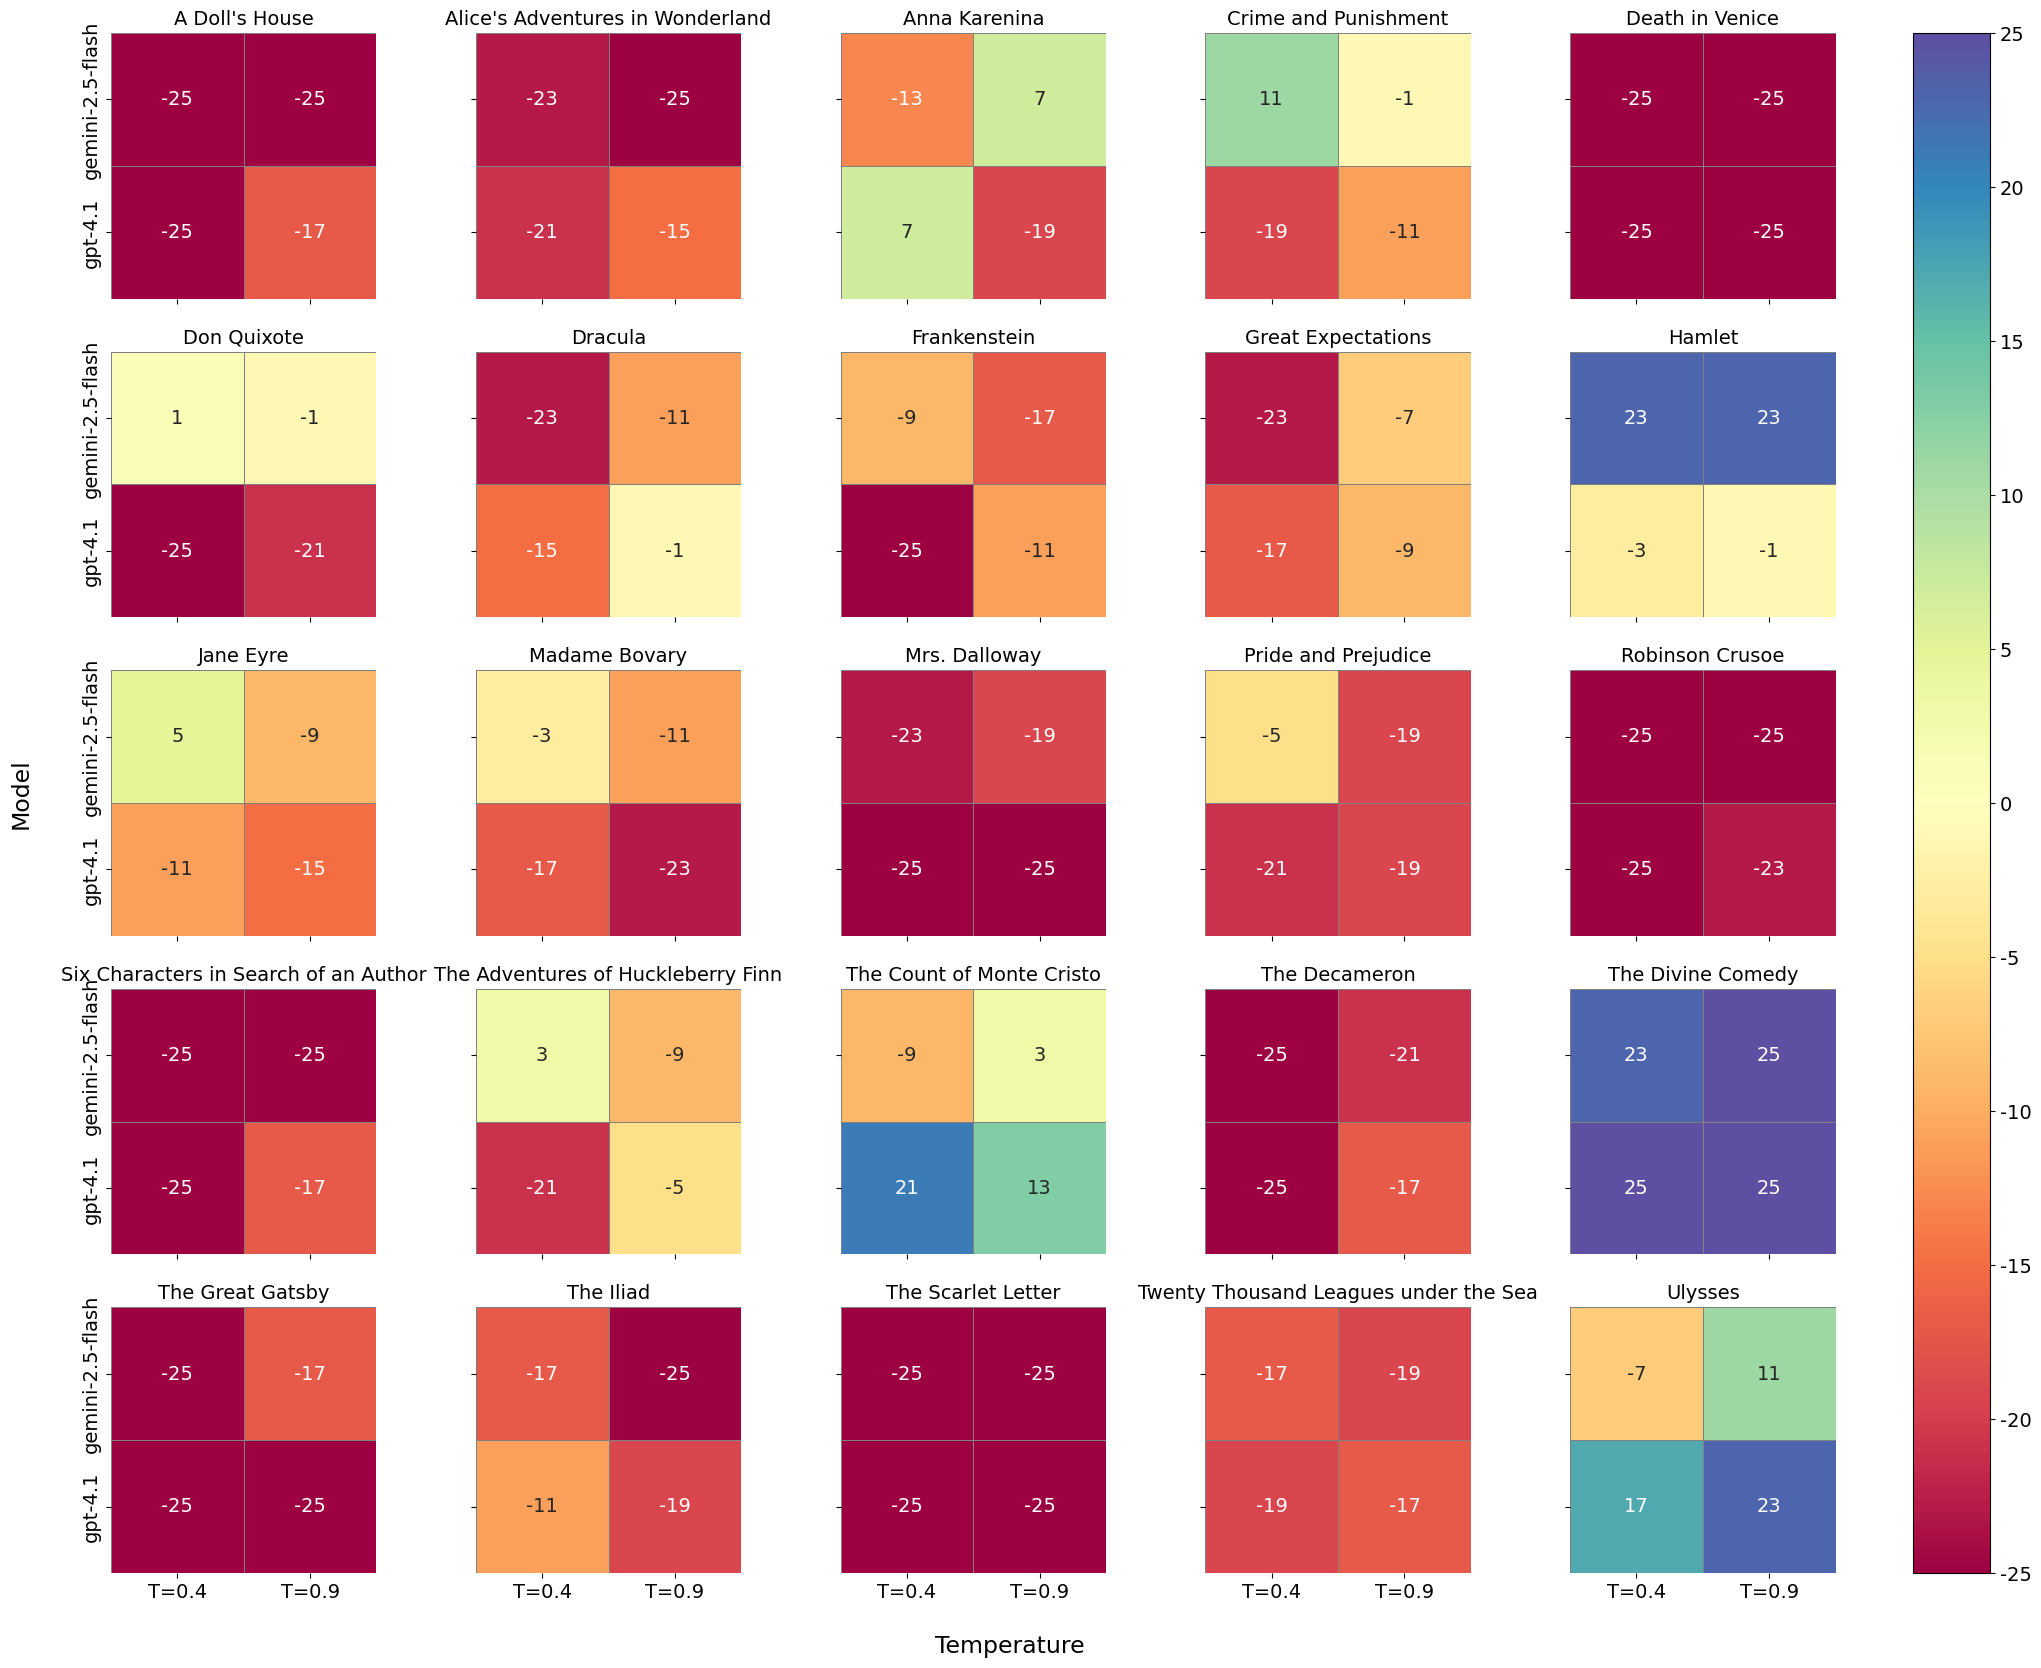

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# ==== 参数设置 ====
folder_path = "results_in_vs_ex"
csv_files = [f for f in os.listdir(folder_path) if f.endswith("_extracted.csv")]

generators = []  # 会在读取时自动记录不同 generator
temperatures = []  # 会在读取时自动记录不同 temperature
data_dict = {}  # key = (generator, temperature), value = df with summed scores per book

# ==== 读取 CSV 并汇总每本书的 result_extract ====
for filename in csv_files:
    match = re.search(r'generator_(.+)_temperature_([0-9.]+)_extracted', filename)
    if not match:
        continue
    generator = match.group(1)
    temperature = float(match.group(2))

    if generator not in generators:
        generators.append(generator)
    if temperature not in temperatures:
        temperatures.append(temperature)

    df = pd.read_csv(os.path.join(folder_path, filename))
    df["book_title"] = df["book_title"].apply(lambda x: x.split("-")[0].replace("_", "'"))
    # 检查每本书是否有25行
    counts = df.groupby("book_title").size()
    for book, count in counts.items():
        if count != 25:
            print(f"⚠️ 文件 {filename}, 书籍 '{book}' 数据行数 = {count} (应为25)")

    # 按 book_title 求和
    summed = df.groupby("book_title")["result_extract"].sum().reset_index()
    data_dict[(generator, temperature)] = summed

# ==== 获取所有书名（假设每个 CSV 的书名一致） ====
book_titles = list(data_dict[list(data_dict.keys())[0]]["book_title"])

# ==== 绘制每本书的 2x2 热力图 ====
cols = 5
rows = int(np.ceil(len(book_titles) / cols))
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
axes = axes.flatten()

# 设置颜色范围
all_scores = np.concatenate([df["result_extract"].values for df in data_dict.values()])
vmin, vmax = np.min(all_scores), np.max(all_scores)
fontsize = 14

for i, book in enumerate(book_titles):
    # 构造 2x2 矩阵
    matrix = np.zeros((2, 2))
    annot_matrix = np.empty((2, 2), dtype=object)
    for r, generator in enumerate(generators):
        for c, temperature in enumerate(temperatures):
            key = (generator, temperature)
            df = data_dict.get(key)
            if df is not None:
                score_row = df[df["book_title"] == book]
                if not score_row.empty:
                    matrix[r, c] = score_row["result_extract"].values[0]
                    annot_matrix[r, c] = f"{matrix[r, c]:.0f}"

    df_matrix = pd.DataFrame(matrix, index=generators, columns=[f"T={t}" for t in temperatures])
    sns.heatmap(df_matrix, annot=annot_matrix, fmt='', cmap="Spectral",
                cbar=False, vmin=vmin, vmax=vmax,
                linewidths=0.5, linecolor="gray",
                ax=axes[i], square=True, annot_kws={"size": fontsize})
    axes[i].set_title(book, fontsize=fontsize)

# 去掉多余子图
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# 全局标签
fig.text(0.5, 0.07, "Temperature", ha='center', fontsize=fontsize+3)
fig.text(0.1, 0.5, "Model", va='center', rotation='vertical', fontsize=fontsize+3)

# 统一 colorbar
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.04)
# cbar.set_label("Summed Score", fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_ticks(np.linspace(vmin, vmax, num=11))
cbar.set_ticklabels([f"{x:.0f}" for x in np.linspace(vmin, vmax, num=11)])

# 调整每个子图的 tick 显示
for i, ax in enumerate(axes):
    row, col = divmod(i, cols)
    if col != 0:  # 非最左列
        ax.set_ylabel("")
        ax.set_yticklabels([])
    else:  # 最左列显示 ytick
        ax.tick_params(axis='y', labelsize=fontsize)
    if row != rows - 1:  # 非最底行
        ax.set_xlabel("")
        ax.set_xticklabels([])
    else:  # 最底行显示 xtick
        ax.tick_params(axis='x', labelsize=fontsize)

# plt.tight_layout()
plt.savefig(f'Figures/in_vs_out.png', dpi=300, bbox_inches='tight')
plt.show()
